# xDB Training

A notebook exploring the xDB dataset tier3 part for Building Segmentation Model and Damaged Classification Model

In [1]:
# In a Jupyter notebook or IPython environment, run this in the first cell
%load_ext autoreload
%autoreload 2

In [63]:
%reload_ext autoreload

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Define the transformation pipeline
def get_train_augmentation_pipeline(image_size=(256, 256)):
    transform = A.Compose([
        # Resize images and masks
        A.Resize(image_size[0], image_size[1], p=1.0),  # Ensure both image and mask are resized
        # Random horizontal flip
        A.HorizontalFlip(p=0.8),
        # Random vertical flip
        A.VerticalFlip(p=0.8),
        # Random rotation
        A.RandomRotate90(p=0.05),
        # Random brightness and contrast adjustments
        A.RandomBrightnessContrast(p=0.2),
        # Random contrast adjustment
        A.RandomGamma(p=0.2),
        # Random scale and aspect ratio change
        A.RandomSizedCrop(min_max_height=(image_size[0], image_size[1]), size=(image_size[0], image_size[1]), p=0.8, w2h_ratio=0.5),
        # Random blur
        A.GaussianBlur(p=0.2),
        # Convert to tensor (works for both image and mask)
        ToTensorV2()
    ])
    return transform

def get_val_augmentation_pipeline(image_size=(256, 256)):
    transform = A.Compose([
        # Resize images and masks
        A.Resize(image_size[0], image_size[1], p=1.0),  # Ensure both image and mask are resized
        ToTensorV2()
    ])
    return transform

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from datasets import xDB_Damaged_Building

origin_dir = "../data/xDB/tier3"

data_train  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_train_augmentation_pipeline(image_size=(512,512)),
    type="train",
    val_ratio=0.1, 
    test_ratio=0.1,
)

data_val  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_val_augmentation_pipeline(image_size=(512,512)),
    type="val",
    val_ratio=0.1, 
    test_ratio=0.1,
)

data_test  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_val_augmentation_pipeline(image_size=(512,512)),
    type="test",
    val_ratio=0.1, 
    test_ratio=0.1,
)

Loaded 5097 train labels.
Loaded 636 val labels.
Loaded 636 test labels.


In [6]:
from models import ResNet_UNET 

model = ResNet_UNET(
        in_channels=3,
        out_channels=2,
        backbone_name="resnet34",
        pretrained=True,
        freeze_backbone=False,
    )

In [7]:
import torch
from torchsummary import summary 
# Before training, wrap the model for Data Parallelism
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = torch.nn.DataParallel(model)

model.to("cuda")

summary(model, input_size=(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [8]:
from torch.utils.data import DataLoader
train_dl = DataLoader(data_train, batch_size=16, shuffle=True, num_workers=6, pin_memory=True,drop_last=True)
val_dl = DataLoader(data_val, batch_size=8, shuffle=False, num_workers=6, pin_memory=True)

In [9]:
from torch.nn.modules.loss import _Loss
from typing import List

class Ensemble(_Loss):
    def __init__(
        self,
        list_losses: List[_Loss] = [],
        weights: List[float] = []
    ):
        super().__init__()
        self.list_losses = list_losses
        self.weights = weights

        assert len(list_losses) > 0, "List of losses cannot be empty."
        assert len(weights) == len(list_losses), "Weights must match the number of losses."

        # Normalize weights to sum to 1
        total_weight = sum(self.weights)
        assert total_weight > 0, "Weights must sum to a positive value."
        self.weights = [w / total_weight for w in self.weights]

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Computes the weighted ensemble loss.
        
        :param inputs: Predictions from the model.
        :param targets: Ground truth labels.
        :return: Weighted ensemble loss.
        """
        total_loss = 0.0
        for weight, loss_fn in zip(self.weights, self.list_losses):
            loss = loss_fn(inputs, targets)
            total_loss += weight * loss
        
        return total_loss


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from training import train 
from losses import SoftCrossEntropyLoss
from losses import DiceLoss, FocalLoss
from metrics import accuracy, f1_score, iou_score

mode = "multiclass"
optimizer = optim.AdamW(params=filter(lambda p: p.requires_grad, model.parameters()), lr=0.00015, weight_decay=1e-6)
params_opt = {}
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 11, 17, 25, 33, 47, 50, 60, 70, 90, 110, 130, 150, 170, 180, 190], gamma=0.5)

params_sc = {}
criterion = Ensemble(list_losses=[DiceLoss(mode=mode), FocalLoss(mode=mode)], weights= [1.0,10.0]).cuda() #nn.CrossEntropyLoss(weight=torch.tensor([0.4, 0.6]).to("cuda"))
# Define Metrics 
metrics = [accuracy, f1_score, iou_score]

# Early Stopping 
early_stopping_params = {"patience":5, "trigger_times": 0}

torch.cuda.empty_cache()
train(
    model,
    train_dl=train_dl,
    valid_dl=val_dl,
    optimizer=optimizer,
    scheduler=scheduler,
    params_opt=params_opt,
    params_sc=params_sc,
    metrics=metrics,
    nb_epochs=55,
    loss_fn=criterion,
    experiment_name="xDB_UNet_test",
    log_dir="../runs",
    model_dir="../models",
    early_stopping_params = early_stopping_params,
    image_key="image",
    training_log_interval=1,
    verbose=False,
    is_mixed_precision=True
)


In [68]:
test_dl = DataLoader(data_test, batch_size=5, shuffle=True)

In [69]:
input_test = next(iter(test_dl))
outputs = model.predict(input_test["image"].to("cuda"))

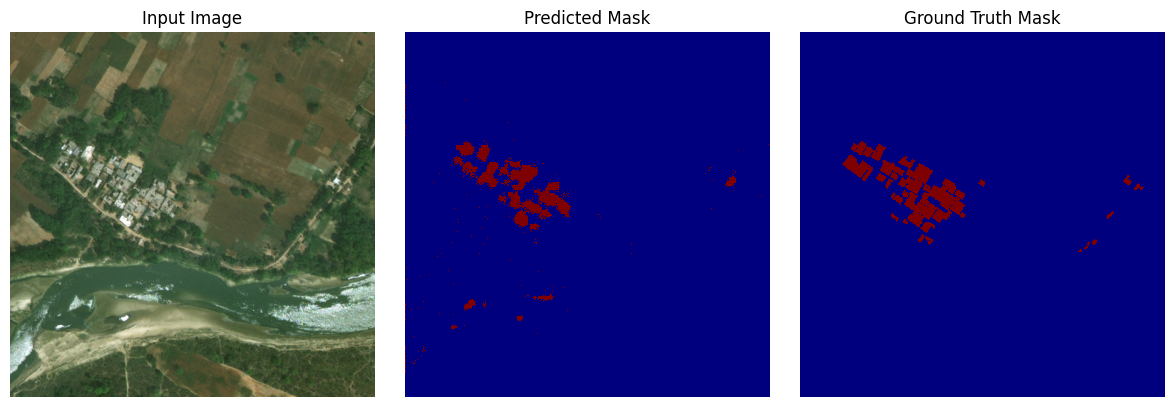

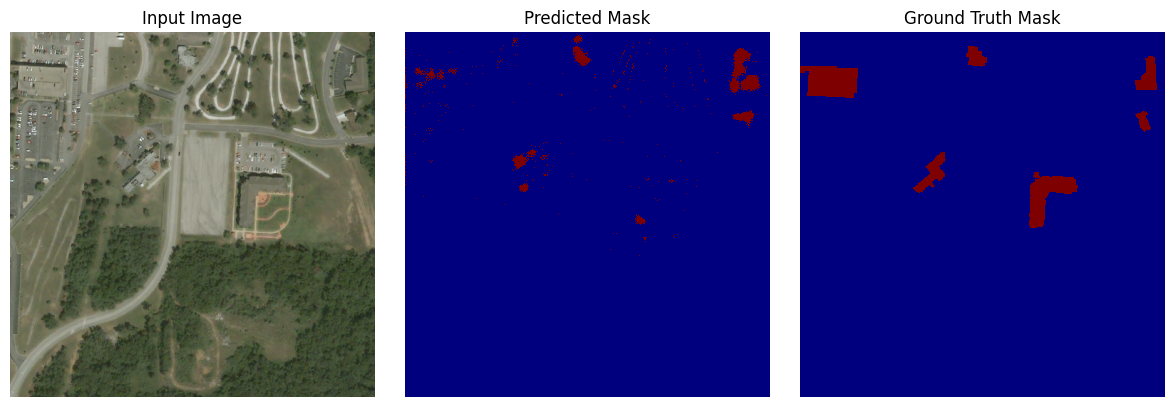

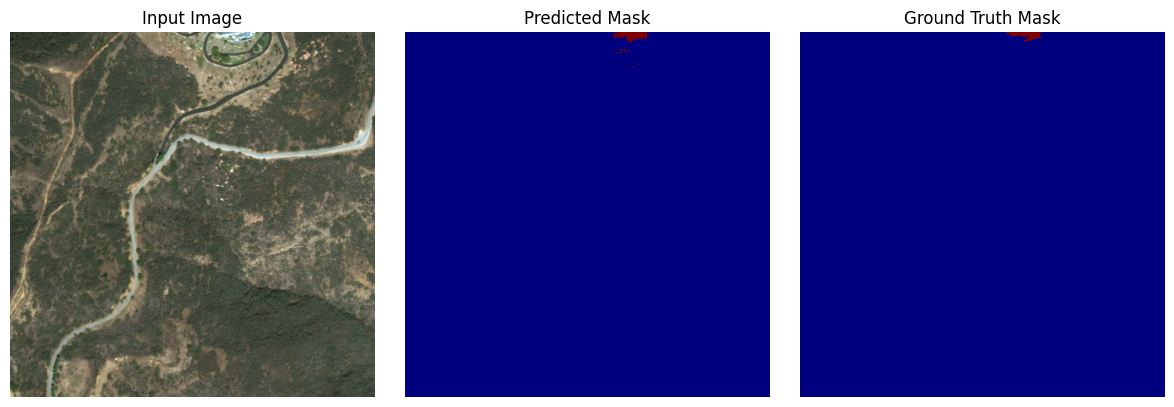

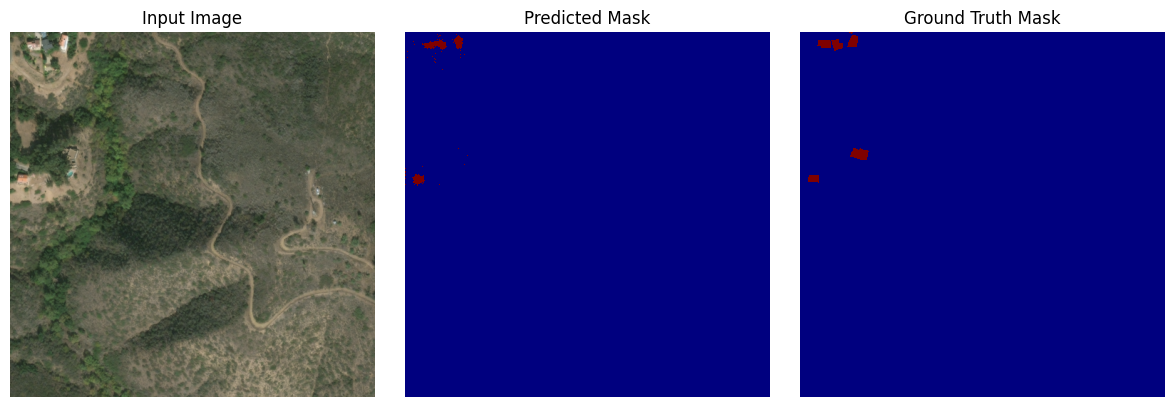

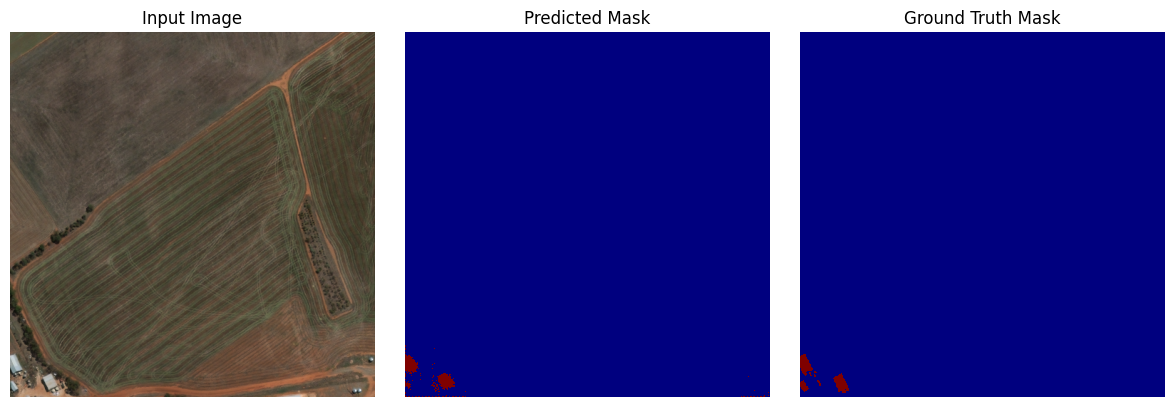

In [70]:
from utils import display_predictions_batch

display_predictions_batch(
    images=input_test["image"],
    mask_predictions=outputs,
    mask_labels=input_test["mask"]
    )

In [67]:
from training import testing 
from metrics import (f1_score,
    iou_score,
    balanced_accuracy
    )

weights = [[0, 1],[0.1, 0.9],[0.2, 0.8],[0.3, 0.7],[0.4, 0.6],[0.5, 0.5]]  # Different class weight combinations

for class_weights in weights:  # Iterate over different class weight combinations
    print(f"\nTesting with class weights: {class_weights}")
    
    avg_loss, averaged_metrics = testing(
        model=model,
        test_dataloader=test_dl,  # Assuming `test_dl` is your DataLoader for test data
        loss_fn=criterion,
        metrics=[
            f1_score, 
            iou_score, 
            balanced_accuracy
        ], 
        image_key="image",  # Assuming test_dl provides image tensors under this key
        num_classes=2,  # Assuming binary segmentation
        is_mixed_precision=True,  # Use mixed precision for testing if applicable
        verbose=True,
        reduction="weighted",  # Using weighted reduction
        class_weights=class_weights
    )
    
    print("Testing Loss:", avg_loss)
    print("Model Metrics on the Test Set:")
    for name, value in averaged_metrics.items():
        print(f"{name} = {value}")


Testing with class weights: [0, 1]


Testing:   0%|          | 0/64 [00:00<?, ?batch/s]

Testing: 100%|██████████| 64/64 [00:34<00:00,  1.84batch/s, Loss=0.24] 


Testing Loss: 0.2555227214060489
Model Metrics on the Test Set:
f1_score = 0.6316221356391907
iou_score = 0.470750629901886
balanced_accuracy = 0.7895861268043518

Testing with class weights: [0.1, 0.9]


Testing: 100%|██████████| 64/64 [00:34<00:00,  1.85batch/s, Loss=0.282]


Testing Loss: 0.25550047945488924
Model Metrics on the Test Set:
f1_score = 0.6862667202949524
iou_score = 0.5372713804244995
balanced_accuracy = 0.8018075823783875

Testing with class weights: [0.2, 0.8]


Testing: 100%|██████████| 64/64 [00:35<00:00,  1.83batch/s, Loss=0.247]


Testing Loss: 0.2555269870274472
Model Metrics on the Test Set:
f1_score = 0.7129417061805725
iou_score = 0.5797074437141418
balanced_accuracy = 0.7981458306312561

Testing with class weights: [0.3, 0.7]


Testing: 100%|██████████| 64/64 [00:34<00:00,  1.85batch/s, Loss=0.287]


Testing Loss: 0.2555014713661476
Model Metrics on the Test Set:
f1_score = 0.7519799470901489
iou_score = 0.6347607970237732
balanced_accuracy = 0.7985049486160278

Testing with class weights: [0.4, 0.6]


Testing: 100%|██████████| 64/64 [00:35<00:00,  1.83batch/s, Loss=0.288]


Testing Loss: 0.2555084834871052
Model Metrics on the Test Set:
f1_score = 0.7860669493675232
iou_score = 0.6848582625389099
balanced_accuracy = 0.8001018166542053

Testing with class weights: [0.5, 0.5]


Testing: 100%|██████████| 64/64 [00:34<00:00,  1.84batch/s, Loss=0.241]

Testing Loss: 0.25546974688768387
Model Metrics on the Test Set:
f1_score = 0.8208732604980469
iou_score = 0.7372741103172302
balanced_accuracy = 0.8001319766044617


Testing loss :  0.2548103557442719
Model Metrics on the Test Set : 
f1_score = 0.6712046265602112
iou_score = 0.5252513885498047
balanced_accuracy = 0.7995531558990479
